# Tutorial about Sweeper: AB oscillations

## Basic imports

In [1]:
import sys, os
import tempfile
import numpy as np
import matplotlib.pyplot as plt
from qcodes import Parameter, DelegateParameter, initialise_or_create_database_at, load_or_create_experiment, load_by_id

# Let's create a dummy qcodes database
db_path = os.path.join(tempfile.gettempdir(),'test.db')
initialise_or_create_database_at(db_path)
experiment = load_or_create_experiment(experiment_name='test',sample_name='no sample')

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\manip.batm\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : C:\Users\manip.batm\.qcodes\logs\230308-22600-qcodes.log


(<Figure size 800x400 with 1 Axes>, <Axes: >)

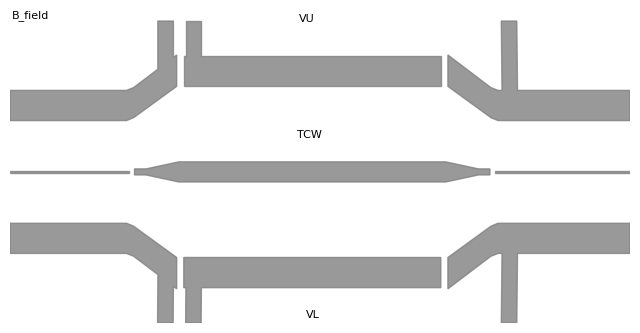

In [2]:
import qube
from qube.layout.gds import LayoutGDS, ConfigShapes
layout = LayoutGDS(
    gdspath=os.path.join('gds','AB.gds'),
    content=None,
)
labels = ['B_field','VU','TCW','VL']
texts = layout.view.texts
for ti, label in zip(texts, labels):
    ti.label = label
layout.plot()

## Create parameters

In [3]:
# Let's create some dummy parameters
from qcodes.validators import Numbers, Bool

VU = Parameter('VU', unit='V', set_cmd=None, get_cmd=None, initial_value=0, vals=Numbers(-2, 0)) 
VL = Parameter('VL', unit='V', set_cmd=None, get_cmd=None, initial_value=0, vals=Numbers(-2, 0)) 
TCW = Parameter('TCW', unit='V', set_cmd=None, get_cmd=None, initial_value=0, vals=Numbers(-2, 0))
B = Parameter('B_field', unit='T', set_cmd=None, get_cmd=None, initial_value=0, vals=Numbers(-2, 2))

IU = Parameter('I_up', unit='pA', set_cmd=None, get_cmd=lambda: 0) # always returns 0
IL = Parameter('I_low', unit='pA', set_cmd=None, get_cmd=np.random.random) # random number

## Sweep B vs (VU and VL, both at the same time)

### Simple example

In [4]:
from qube.measurement.sweeper import Sweeper
sw = Sweeper()
" Sweep first B and then VU and VL at the same time "
sw.sweep_linear(B,-1,1,dim=1) 
sw.sweep_linear(VU,-0.5,-1.0,dim=2) 
sw.sweep_linear(VL,-0.5,-1.0,dim=2) 

" Set readouts "
sw.set_readouts(IU,IL)

" Points to sweep with 20 repetitions"
sw.set_sweep_shape([5,7,20]) 

" Execute sweep "
run_id = sw.execute() # it returns the run_id

Starting experimental run with id: 63. 
The measurement will take 0:00:00


  0%|          | 0/700 [00:00<?, ?it/s]

## Types of sweep instructions
There are few pre-determined types:

- .sweep_linear(param, init, final, dim)
- .sweep_log(param, init, final, dim)
- .sweep_step(param, init, step_size, dim)
- .sweep_values(param, values, dim)
- .sweep_custom(param, f, dim) --> f is a function to generate sweep values with a given number of pts. values = f(pts)

### Same but with more customized execution

In [5]:
sw = Sweeper()
" Set static conditions before and after sweep "
static = {
    VU:-0.3,
    VL:-0.3,
    TCW:-0.75,
    B:0,
}
sw.set_start_at(static)
sw.set_return_to(static) # return to same condition in this example

" Sweep first B and then VU and VL at the same time "
sw.sweep_linear(B,-1,1,dim=1) 
sw.sweep_linear(VU,-0.5,-1.0,dim=2) 
sw.sweep_linear(VL,-0.5,-1.0,dim=2) 

" Set readouts "
sw.set_readouts(IU,IL)
sw.pre_readout_wait = 0.01 # s (optional)
sw.post_readout_wait = 0.01 # s (optional)

" Add some pre and post process custom functions "
sw.add_pre_process(lambda: print('Start sweep!'))
sw.add_post_process(lambda: print('End sweep!'))
sw.pre_process_wait = 0.5 #s
sw.post_process_wait = 0.5 #s

" Add some pre and post readout custom functions "
# sw.add_pre_readout(lambda: print('pre-readout'))
# sw.add_post_readout(lambda: print('post-readout'))

" Points to sweep with 2 repetitions"
sw.set_sweep_shape([5,7,2]) 

" Execute sweep "
run_id = sw.execute() # it returns the run_id

Start sweep!
Starting experimental run with id: 64. 
The measurement will take 0:00:02.157626


  0%|          | 0/70 [00:00<?, ?it/s]

End sweep!


### Execution sequence

In [6]:
help(Sweeper.execute)

Help on function execute in module qube.measurement.sweeper:

execute(self, test_run=False, **kwargs) -> int
    Sweep execution with the following order:
    1. Go to start_at
    2. Apply pre_process + wait
    3. Save initial static {param: value}
    4. Enter sweep loop
        4.1 Apply {param: value}
        4.2 Apply pre_readout + wait
        4.3 Readout + save
        4.4 Apply post_readout + wait
        4.5 Execute callback
        4.5 Go to next index and repeat from 4.1 until finish all steps
    5. Apply post_process + wait
    7. Go to return_to
    8. Save final static {param: value}
    
    kwargs:
        test_run: if it is True, it will execute the sweep without changing any parameter nor readout.
        Rest of kwargs are the same as .set_config
    
    Returns:
        datasaver.run_id



### Alternative way to do the same (although not recommended)

In [7]:
sw = Sweeper()
sw.set_config(
    instructions=[
        [1, B, np.linspace(-1,1,5)],
        [2, VU, np.linspace(-0.5,-1.0,7)],
        [2, VL, np.linspace(-0.5,-1.0,7)],
        [3, None, 2],
    ],
#     sweep_shape=[5,7,2],
    start_at=static,
    return_to=static,
    readouts=[IU,IL],
    pre_readout_wait=0.01, # s
    post_readout_wait=0.01, # s
    pre_process = [lambda: print('Start sweep!'),],
    post_process = [lambda: print('End sweep!'),],
    pre_process_wait = 0.5, #s
    post_process_wait = 0.5, #s
)

sw.execute(
    test_run=False,
)

Start sweep!
Starting experimental run with id: 65. 
The measurement will take 0:00:02.181738


  0%|          | 0/70 [00:00<?, ?it/s]

End sweep!


65

### Re-use sweeper: keep pre/post process/readout, wait times, etc...

In [8]:
sw.clear_instructions()
sw.sweep_step(B,0,0.01,dim=1) 
sw.sweep_linear(TCW,-0.2,-1.0,dim=2) 

sw.set_sweep_shape([11,5]) 
run_id = sw.execute()

Start sweep!
Starting experimental run with id: 66. 
The measurement will take 0:00:01.714180


  0%|          | 0/55 [00:00<?, ?it/s]

End sweep!


## Load data from a sweep

In [9]:
" We can checkout the data in the qcodes database "
ds = load_by_id(run_id)

" We can access for example to the swept values "
print(ds.get_parameter_data()['B_field'])
print(ds.get_parameter_data()['TCW'])

{'B_field': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ])}
{'TCW': array([-0.2, -0.4, -0.6, -0.8, -1. ])}


In [10]:
print(ds.get_parameter_data().keys())

dict_keys(['B_field', 'I_low', 'I_up', 'TCW', 'VL', 'VU', 'static_isbools', 'static_labels', 'static_names', 'static_units', 'static_values_final', 'static_values_init', 'sweep_axes_full_names', 'sweep_axes_isbools', 'sweep_axes_names', 'sweep_dims', 'sweep_note', 'sweep_readouts_dim0s', 'sweep_readouts_full_names', 'sweep_readouts_names', 'sweep_shape'])


In [11]:
" Or the readout values of readouts "
print(ds.get_parameter_data()['I_up'])
print(ds.get_parameter_data()['I_low'])

{'I_up': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])}
{'I_low': array([0.72269487, 0.96340627, 0.05565561, 0.50101475, 0.88148158,
       0.11886625, 0.53676028, 0.17674645, 0.90140759, 0.42890557,
       0.43554338, 0.59259237, 0.72204833, 0.02407021, 0.29882343,
       0.08621168, 0.01547459, 0.32962521, 0.49186312, 0.98639727,
       0.84168115, 0.55184299, 0.26962611, 0.92465781, 0.81484069,
       0.02052076, 0.9105961 , 0.23350924, 0.14262012, 0.3421065 ,
       0.53528383, 0.39794875, 0.9715241 , 0.0370272 , 0.40862199,
       0.19474054, 0.36778436, 0.55593507, 0.35850876, 0.46396904,
       0.22038138, 0.5121366 , 0.6613341 , 0.62023652, 0.49014759,
       0.51341056, 0.62433077, 0.24866644, 0.82657283, 0.92380072,
       0.51285812, 0.67169844, 0.64652069, 0.80867059, 0.1792

## Better way to load all the information

In [12]:
from qube.measurement.content import qcodes_to_datafile, run_id_to_datafile
df = run_id_to_datafile(run_id)
print(df) 

Datafile
fullpath: None
statics: 2 elements (keys: ['init', 'final'])
datasets: 2 elements
[0] name: I_up - unit: pA - shape: (11, 5)
	axes: 4 elements
	[0] name: B_field - unit: T - shape: (11,) - dim: 0
	[1] name: TCW - unit: V - shape: (5,) - dim: 1
	[2] name: counter_dim0 - unit: a.u. - shape: (11,) - dim: 0
	[3] name: counter_dim1 - unit: a.u. - shape: (5,) - dim: 1
[1] name: I_low - unit: pA - shape: (11, 5)
	axes: 4 elements
	[0] name: B_field - unit: T - shape: (11,) - dim: 0
	[1] name: TCW - unit: V - shape: (5,) - dim: 1
	[2] name: counter_dim0 - unit: a.u. - shape: (11,) - dim: 0
	[3] name: counter_dim1 - unit: a.u. - shape: (5,) - dim: 1


In [13]:
df.statics

{'init': [Static - name: B_field - unit: T - value: 0.0,
  Static - name: VU - unit: V - value: -0.3,
  Static - name: VL - unit: V - value: -0.3,
  Static - name: TCW - unit: V - value: -0.75],
 'final': [Static - name: B_field - unit: T - value: 0.0,
  Static - name: VU - unit: V - value: -0.3,
  Static - name: VL - unit: V - value: -0.3,
  Static - name: TCW - unit: V - value: -0.75]}

## Let's explore the static configurations

We will use a SweeperContent instance which is the engine behind run_id_to_datafile.

In [14]:
from qube.measurement.content import SweeperContent
ds = load_by_id(run_id)
cont = SweeperContent(ds)
cont.statics

{'init': [Static - name: B_field - unit: T - value: 0.0,
  Static - name: VU - unit: V - value: -0.3,
  Static - name: VL - unit: V - value: -0.3,
  Static - name: TCW - unit: V - value: -0.75],
 'final': [Static - name: B_field - unit: T - value: 0.0,
  Static - name: VU - unit: V - value: -0.3,
  Static - name: VL - unit: V - value: -0.3,
  Static - name: TCW - unit: V - value: -0.75]}

In [15]:
cont.axes

[Axis - name: B_field - unit: T - shape: (11,) - dim: 0,
 Axis - name: TCW - unit: V - shape: (5,) - dim: 1,
 Axis - name: counter_dim0 - unit: a.u. - shape: (11,) - dim: 0,
 Axis - name: counter_dim1 - unit: a.u. - shape: (5,) - dim: 1]

In [16]:
cont.datasets

[name: I_up - unit: pA - shape: (11, 5)
 axes: 4 elements
 	[0] name: B_field - unit: T - shape: (11,) - dim: 0
 	[1] name: TCW - unit: V - shape: (5,) - dim: 1
 	[2] name: counter_dim0 - unit: a.u. - shape: (11,) - dim: 0
 	[3] name: counter_dim1 - unit: a.u. - shape: (5,) - dim: 1,
 name: I_low - unit: pA - shape: (11, 5)
 axes: 4 elements
 	[0] name: B_field - unit: T - shape: (11,) - dim: 0
 	[1] name: TCW - unit: V - shape: (5,) - dim: 1
 	[2] name: counter_dim0 - unit: a.u. - shape: (11,) - dim: 0
 	[3] name: counter_dim1 - unit: a.u. - shape: (5,) - dim: 1]

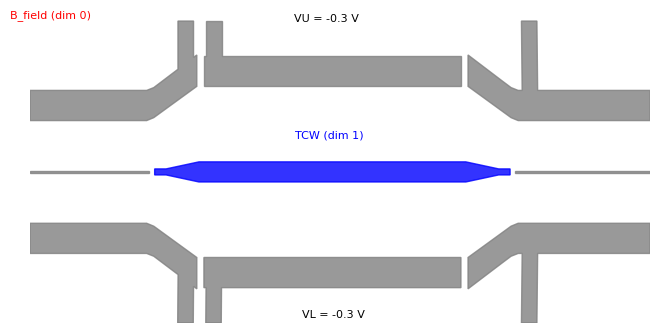

In [17]:
from qube.layout.gds import LayoutGDS, ConfigShapes
layout = LayoutGDS(
    gdspath=os.path.join('gds','AB.gds'),
    content=cont,
    gdsconfig=ConfigShapes(os.path.join('gds','AB.ini'))
)
layout.apply_content_to_view()
fig, ax = layout.plot()